# Session 4: Policy-gradient Pong

## Setups

In [1]:
# #uncomment only if you're running from google colab
# !git clone https://github.com/Datatouille/rl-workshop
# !mv rl-workshop/* .
# !ls
# !pip install gym[atari] #For full installations, see https://github.com/openai/gym#installation
# !pip install numpy torchvision_nightly
# !pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
# import torch
# torch.__version__

## Imports

In [1]:
%matplotlib inline

#environments
import gym
from solutions.environments import Gridworld

#torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
#use cuda 0 if available; assuming 1 gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#misc
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from datetime import datetime
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

MODEL_PATH = 'models/'

## Recap

Environments we have solved so far:
* Gridworld
* Blackjack-v0
* Taxi-v2

**Coding Assignment** What do they have in common? Find out what are the states and actions of each environment above.

In [2]:
#create environments
gridworld_env = Gridworld()
bj_env = gym.make('Blackjack-v0')
taxi_env = gym.make('Taxi-v2')

'''
Write your code here
'''

'\nWrite your code here\n'

**Hints** 
* `env.reset()` returns the initial state of an environment.
* `env.action_space` returns the action space of the environment.
* `env.observation_space` or `env.state_space` returns the state space of the environment.

## What Got You Here Will Not Take You There

So far our methods of finding the optimal policy has been:

1. Predict the action values given a state using either **a sample of transitions (Monte Carlo)** or **previous action values (Temporal Difference)**.
2. Store those values in a dictionary `Q[state][action]`
3. To perform an optimal action, choose the action index which gives the highest action value in the dictionary.

But what if we have infinitely many states?

## [Pong-v0](https://github.com/openai/gym/blob/master/gym/envs/atari/atari_env.py)

One of the most influential articles on deep reinforcement is Andrej Karpathy's [Deep Reinforcement Learning: Pong from Pixels](https://karpathy.github.io/2016/05/31/rl/), where he details how to train an agent that learns to play Atari Pong from raw pixels using a technique called **policy gradient**. This session will borrow heavily from this article as well as [a lecture by David Silver](http://www0.cs.ucl.ac.uk/staff/D.Silver/web/Teaching_files/pg.pdf).

If you are too young to be familiar with Pong, try it [here](http://www.pongonline.net/).

In [4]:
%%HTML
<iframe width="560" height="315" src="https://www.youtube.com/embed/YOW8m2YGtRg" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

**Coding Assignment** Before we dive in, let us do some warm-up exercises of finding out more about `PongDeterministic-v0`

* State space
* Action space
* Rewards
* How many episodes on average with random actions
* Render one frame and see how it looks like

In [4]:
#create environment
env = gym.make('PongDeterministic-v0')
env.reset()
print(f'Each action index means: {env.unwrapped.get_action_meanings()}')

'''
Write your code here
'''

Each action index means: ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


'\nWrite your code here\n'

## Monte Carlo Policy Gradient aka Vanilla Policy Gradient REINFORCE aka Stochastic Policy Gradient

The gist of it is that instead of using the three steps we have done so far, we do:

1. Get rid of the Q dictionary altogether.
2. Use a neural network called **policy network** that takes the input of state (pixels) and outputs which action to take as our policy.
3. Get **a sample of transitions and discounted rewards** based on that neural network.
4. Optimize the policy network to maximize the **expected discounted rewards** using **gradient ascent**.

<img src="img/pong_pg.png" alt="Pong Policy Gradient"/>

### Preprocess Input

Instead of taking the entire height (210) * width (160) * color channels (3) = 100,800 pixels for input, we prepocess to a black-and-white 80 * 80 image.

(210, 160, 3)


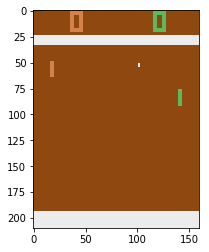

In [6]:
env.reset()
for i in range(50): 
    action = np.random.choice([2,3])
    state, reward, done, info = env.step(action)
pre_img = state
print(pre_img.shape)
plt.imshow(pre_img)

In [7]:
#adapted from https://gist.github.com/karpathy/a4166c7fe253700972fcbc77e4ea32c5
def preprocess_state(I):
    I = I[35:195] # crop
    I = I[::2,::2,0] # downsample by factor of 2
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    res = I.astype(np.float).reshape(-1)
    return(res)

(6400,)


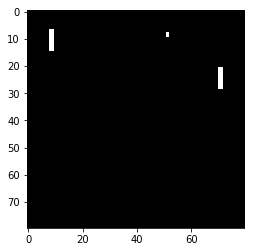

In [8]:
post_img = preprocess_state(pre_img)
print(post_img.shape)
plt.imshow(post_img.reshape(80,80), 'gray')

### Policy Network

We use a policy network that takes an input of state and output the probability of taking an action directly. That is, we are not estimating the action value function $Q(s,a)$ but directly the policy function $\pi(a|s)$.

In [9]:
class PolicyNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(PolicyNet, self).__init__()
        self.fc1 = nn.Linear(input_size,hidden_size)
        self.fc2 = nn.Linear(hidden_size,output_size)
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x),1)
        return(x)
    
#initiate random policy
policy = PolicyNet(6400,512,2)
optimizer = optim.Adam(policy.parameters(), lr=1e-3)

In [10]:
state = env.reset()
x = torch.FloatTensor(preprocess_state((state)))[None]
x.shape

torch.Size([1, 6400])

In [11]:
#policy probability; pi
#function output log softmax
pi = policy(x)
pi

tensor([[0.4939, 0.5061]], grad_fn=<SoftmaxBackward>)

In [12]:
#choose action; +2 because the indice we want are 2 and 3
np.random.choice([2,3], p = pi.squeeze().detach().numpy())

3

**Coding Assignment** Use the randomly initiated policy network to play the game for 30 episodes. 
* What is the average reward across all episodes?
* How many times the agent chose to go left or right?

Note that in line with [Karpathy's implementation](https://gist.github.com/karpathy/a4166c7fe253700972fcbc77e4ea32c5), we will be using the difference of frames as our state.

In [264]:
scores = []
actions = []

for i in range(30):
    #initial state
    state = preprocess_state(env.reset())
    previous_state = None
    
    #start game
    env.step(1)
    #do some random steps
    for i in range(10): 
        action = np.random.choice([2,3])
        env.step(action)
    
    score = 0
    while True:
        #get input state as difference between two states
        current_state = state
        input_state = current_state - previous_state if previous_state is not None else np.zeros(80*80)
        previous_state = current_state
        #convert input to tensor
        state_tensor = torch.FloatTensor(input_state)[None]

        '''
        Write codes to get probability and choose action here
        '''
        
        #record action
        actions.append(action)
        #environment step
        state, reward, done, info = env.step(action)
        #record score
        score+=reward
        #preprocess new state
        state = preprocess_state(state)
        if done: break
    #append scores
    scores.append(score)
    
plt.hist(scores)
print(np.mean(scores))
print(Counter(actions))

### Trajectories

With Monte Carlo methods, we collect all state-action pairs in an episode then update the Q dictionary once the episode ends. It is not very efficient since we always have to wait for the end of the episode. Here instead we will come up with an arbitrary number of timesteps and treat it as though it is an episode, calling it **trajectory**.

In [13]:
#for a single episode
def get_trajectories(policy, env, t_max=300):
    trajectories = []

    #initialize state
    state = preprocess_state(env.reset())
    previous_state = None
    
    #start game
    env.step(1)
    #do some random steps
    for i in range(10): 
        action = np.random.choice([2,3])
        env.step(action)

    while True:
        #each trajectory
        states= []
        actions = []
        rewards = []
        probs = []
        for t in range(t_max):
            #get input state as difference between two states
            current_state = state
            input_state = current_state - previous_state if previous_state is not None else np.zeros(80*80)
            previous_state = current_state
            #convert input to tensor
            state_tensor = torch.FloatTensor(input_state)[None]
            #get probability of doing an action
            prob = policy(state_tensor).squeeze().detach().numpy()
            #select action based on probability
            action = np.random.choice([2,3],p=prob)
            #environment step
            state, reward, done, info = env.step(action)

            #append trajectories
            probs.append(prob[action-2])
            states.append(input_state)
            actions.append(action-2)
            rewards.append(reward)
            #preprocess next state
            state = preprocess_state(state)
            if done: break
        if done: break
        trajectories.append((probs, states,actions,rewards))
    return(trajectories)

In [14]:
trajectories = get_trajectories(policy,env)
len(trajectories)

2

### Gradient Ascent

The last and most important step is to optimize the policy network so that given a state, it will be more likely to perform an action that would maximize the **expected discounted rewards** $U(\theta)$:

$$U(\theta) = \sum_{\tau} P(\tau;\theta) R(\tau) = \frac{1}{m}\sum_{i=1}^{m} \sum_{t=0}^{H}log\pi_{\theta}(a^i_t|s^i_t)R(\tau^i) = \frac{1}{m}\sum_{i=1}^{m} \sum_{t=0}^{H}log\pi_{\theta}(a^i_t|s^i_t)R(\tau^i)$$

where
* $\tau$ is a trajectory
* $\theta$ is a set of parameters for the policy network
* $P(\tau; \theta)$ is the probability of trajectory $\tau$ given parameters $\theta$
* $R(\tau)$ is the discounted rewards of trajectory $\tau$
* $i$ denotes a trajectory
* $t$ denotes a timestep within a trajectory

In human terms, 
1. Collect some trajectories with some number of timesteps, say 300 since it's about half the game.
2. For each trajectory we have, find the sum of log(probability of action we did) * discounted rewards of that trajectory.
3. Decide if how often you want to update your policy network. For instance, if you want to update every 5 trajectories, average 2. calculated from all 5 of them.
4. Perform gradient ascent to update the policy network.

In [15]:
def surrogate(policy, trajectory, discount = 0.995, beta=0.01):
    #expand trajectories
    probs,states,actions,rewards = trajectory

    #calculate normalized future rewards
    #get discount rates
    discount = discount**np.arange(len(rewards))
    #get discounted rewards and expand to number of timesteps collected
    rewards = np.array(rewards)*discount[:,np.newaxis]
    #get discounted rewards for each timestep
    rewards_future = rewards[::-1].cumsum(axis=0)[::-1]
    #normalize the rewards to stabilize things
    mean = np.mean(rewards_future, axis=1)
    std = np.std(rewards_future, axis=1) + 1.0e-10
    rewards_normalized = (rewards_future - mean[:,np.newaxis])/std[:,np.newaxis]

    #convert trajectory into tensors
    actions = torch.tensor(actions, dtype=torch.long, device=device)
    old_probs = torch.tensor(probs, dtype=torch.float, device=device)
    rewards = torch.tensor(rewards_normalized, dtype=torch.float, device=device)
    states = torch.tensor(states, dtype=torch.float, device=device)
    new_probs = policy(states).gather(1,actions.reshape(-1,1)).squeeze()

    #ratio or log
    ratio = new_probs/old_probs
#     ratio = torch.log(new_probs)

    #regularization term
    reg = -(new_probs*torch.log(old_probs+1.e-10)+ (1.0-new_probs)*torch.log(1.0-old_probs+1.e-10))
    return(torch.mean(ratio*rewards + beta*reg))

In [17]:
trajectory = trajectories[0]
L = surrogate(policy,trajectory)
L

tensor(0.0069, grad_fn=<MeanBackward1>)

## Training

In [20]:
episode = 3000
epsilon = 0.1
beta = .01
# keep track of progress
scores = []

for e in trange(episode):
    # collect trajectories
    trajectories = get_trajectories(policy,env,t_max=700)
    score = 0
    
    #update with each trajectory
    for trajectory in trajectories:
        probs, states, actions, rewards = trajectory
        score+= np.sum(rewards)
        L = -surrogate_clipped(policy, trajectory, epsilon=epsilon, beta=beta)

        #run optimizer
        optimizer.zero_grad()
        L.backward()
        optimizer.step()
    
    #record score
    scores.append(score)
    if (e+1) % 100 ==0: 
        last_hundred = np.mean(scores[-100:])
        print(last_hundred)
        if last_hundred > 0: print(f'Solved at {e}')
    
    #decrease exploration as time goes on
    beta*=.995
    epsilon*=.999

  3%|▎         | 100/3000 [03:01<1:27:34,  1.81s/it]

-14.49


  7%|▋         | 200/3000 [05:50<1:21:46,  1.75s/it]

-18.84


 10%|█         | 300/3000 [08:30<1:16:32,  1.70s/it]

-18.15


 10%|█         | 301/3000 [08:31<1:16:30,  1.70s/it]

KeyboardInterrupt: 

### Bonus: How to Derive Gradients of Policy Network

<img src="img/reinforce_derivation1.png" alt="Derivation 1"/>
<img src="img/reinforce_derivation2.png" alt="Derivation 2"/>

## Proximal Policy Optimization (PPO)

In [18]:
def surrogate_clipped(policy, trajectory, discount = 0.995, epsilon=0.1, beta=0.01):
    #expand trajectories
    probs, states,actions,rewards = trajectory

    #calculate normalized future rewards
    #get discount rates
    discount = discount**np.arange(len(rewards))
    #get discounted rewards and expand to number of timesteps collected
    rewards = np.array(rewards)*discount[:,np.newaxis]
    #get discounted rewards for each timestep
    rewards_future = rewards[::-1].cumsum(axis=0)[::-1]
    #normalize the rewards to stabilize things
    mean = np.mean(rewards_future, axis=1)
    std = np.std(rewards_future, axis=1) + 1.0e-10
    rewards_normalized = (rewards_future - mean[:,np.newaxis])/std[:,np.newaxis]

    #convert trajectory into tensors
    actions = torch.tensor(actions, dtype=torch.long, device=device)
    old_probs = torch.tensor(probs, dtype=torch.float, device=device)
    rewards = torch.tensor(rewards_normalized, dtype=torch.float, device=device)
    states = torch.tensor(states, dtype=torch.float, device=device)
    new_probs = policy(states).gather(1,actions.reshape(-1,1)).squeeze()

    #ratio or log
    ratio = new_probs/old_probs
#     ratio = torch.log(new_probs)

    #clip ratio; the only difference between REINFORCE and PPO
    ratio_clipped = torch.clamp(ratio, 1-epsilon, 1+epsilon)
    ratio_final = torch.min(ratio*rewards, ratio_clipped*rewards)
    
    #regularization term
    reg = -(new_probs*torch.log(old_probs+1.e-10)+ (1.0-new_probs)*torch.log(1.0-old_probs+1.e-10))
    return(torch.mean(ratio_final*rewards + beta*reg))

In [19]:
trajectory = trajectories[0]
L = surrogate_clipped(policy,trajectory)
L

tensor(1.0069, grad_fn=<MeanBackward1>)

## Solutions

### Pong Diagnostics

In [6]:
env.observation_space, env.action_space

(Box(210, 160, 3), Discrete(6))

100%|██████████| 30/30 [00:13<00:00,  2.24it/s]


764.0

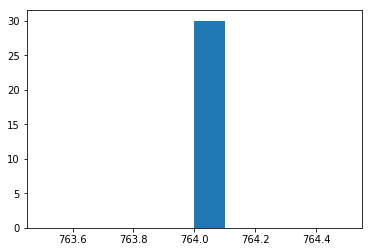

In [22]:
action = np.random.choice([2,3])
ep_lens = []

for i in trange(30):
    env.reset()
    ep_len = 0
    while True:
        ep_len +=1
        state, reward, done, info = env.step(action)
        if done: break
    ep_lens.append(ep_len)
    
plt.hist(ep_lens)
np.mean(ep_lens)

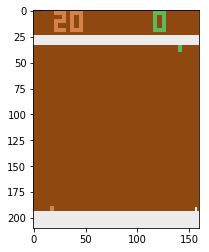

In [21]:
plt.imshow(state)